In [2]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 1550, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1550 (delta 316), reused 367 (delta 288), pack-reused 1151
Receiving objects: 100% (1550/1550), 109.55 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (1146/1146), done.


In [3]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 25.0 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/xgboost/__results__.html
/kaggle/input/xgboost/__notebook__.ipynb
/kaggle/input/xgboost/__output__.json
/kaggle/input/xgboost/custom.css
/kaggle/input/xgboost/__results___files/__results___32_1.png
/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/slim_elastic_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/slim_elastic_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_elastic_all.zip
/kaggle/input/training-tuned-models/custom.css
/kaggle/input/training-tuned-models/Recsys_

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [11]:
config = {
    'tune_parameters': True,
    'n_trials': 150,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [12]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [13]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [14]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.26348679053501006, 'beta': 0.17536156577039744, 'topK': 27}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.2546765833957309,
 'topK': 47}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [21]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [22]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_all.zip', 
)

'/kaggle/working/ials_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 5018.46 column/sec. Elapsed time 4.45 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5466.47 column/sec. Elapsed time 2.38 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3498.30 column/sec. Elapsed time 6.39 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 4072.87 column/sec. Elapsed time 5.49 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 7.56 sec. Users per second: 1383


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081188,0.138907,0.117223,0.039351,0.068515,0.236093,0.127133,0.095933,0.474464,0.302295,...,0.802826,0.380912,0.802826,0.094814,10.776871,0.998458,0.277274,0.83098,1.489542,0.388658


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 7.13 sec. Users per second: 1465


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 7.23 sec. Users per second: 1446


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079705,0.137144,0.115903,0.038052,0.066494,0.230814,0.124391,0.094455,0.472456,0.293971,...,0.802826,0.3793,0.802826,0.101482,10.878388,0.998559,0.296776,0.838808,1.424076,0.392656


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 7.08 sec. Users per second: 1476


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076291,0.127405,0.106782,0.037223,0.064061,0.228078,0.119489,0.088997,0.455241,0.289112,...,0.802826,0.365479,0.802826,0.073174,10.52647,0.998274,0.213989,0.811672,1.329366,0.38781


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 10.47 sec. Users per second: 999


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061448,0.112121,0.096632,0.028523,0.05183,0.190388,0.099346,0.075124,0.40637,0.231987,...,0.802826,0.326244,0.802826,0.011369,7.734762,0.986162,0.033249,0.59641,3.662908,0.323456


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 38.06 sec. Users per second: 275


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.04977,0.080452,0.065896,0.024305,0.039626,0.164113,0.077635,0.056709,0.33005,0.198647,...,0.802826,0.264972,0.802826,0.021805,9.355759,0.998162,0.063766,0.721401,1.208226,0.36722


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 8.65 sec. Users per second: 1209


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 12.06 sec. Users per second: 867


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.087653,0.073131,0.025032,0.04184,0.16867,0.082229,0.061326,0.350803,0.204436,...,0.802826,0.281634,0.802826,0.018374,9.03876,0.997509,0.053734,0.696958,1.421275,0.361566


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 8.33 sec. Users per second: 1256


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.045142,0.077286,0.064945,0.020387,0.036028,0.146509,0.07133,0.053262,0.321442,0.172316,...,0.802826,0.258062,0.802826,0.037469,9.634035,0.996745,0.109574,0.742858,2.066538,0.369834


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 8.10 sec. Users per second: 1291


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.078366,0.13324,0.112339,0.038431,0.066138,0.233643,0.123364,0.092327,0.465474,0.297598,...,0.802826,0.373695,0.802826,0.059913,10.431054,0.998607,0.17521,0.804315,1.504246,0.37625


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 11.59 sec. Users per second: 902


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.064881,0.118057,0.10187,0.030337,0.0556,0.199483,0.105248,0.079273,0.422246,0.244919,...,0.802826,0.33899,0.802826,0.020379,8.300281,0.990375,0.059595,0.640016,3.223771,0.332916


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 12.13 sec. Users per second: 862


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.050038,0.106825,0.10027,0.015507,0.036339,0.105304,0.07494,0.066761,0.361611,0.127808,...,0.802826,0.29031,0.802826,0.031548,9.839125,0.998554,0.092259,0.758672,1.669241,0.360161


In [26]:
cutoff = 30
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = hybrid_similarity.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_46/1353226162.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,ItemID
UserID,
0,35
0,100
0,505
0,122
0,402
...,...
13023,145
13023,9589
13023,334


In [27]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [28]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,122,False
4,0,402,False
...,...,...,...
390715,13023,145,False
390716,13023,9589,False
390717,13023,334,False
390718,13023,349,False


In [29]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    training_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'PureSVD'] = recommender_pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'NMF'] = recommender_nmf._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'PureSVDItem'] = recommender_pure_svd_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'SlimBPR'] = recommender_slim_bpr._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'Slim'] = recommender_slim._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'EaseR'] = recommender_ease_r._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    # training_dataframe.loc[user_id, 'IALS'] = recommender_ials._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

/tmp/ipykernel_46/2546998551.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,NMF,PureSVDItem,SlimBPR,Slim,EaseR
0,0,35,False,2.692282,0.356240,0.267383,0.427287,0.059868,0.079233,3.112596,0.308059,0.070244
1,0,100,False,2.607288,0.266200,0.183766,0.252465,0.496949,0.258350,5.360276,0.185891,0.062951
2,0,505,False,16.224499,0.224652,0.118836,0.080450,0.137467,0.114756,4.261450,0.171841,0.028478
3,0,122,False,57.671581,0.193233,0.136653,0.004174,0.004012,0.000000,4.739450,0.219582,0.007958
4,0,402,False,0.899653,0.153978,0.095036,0.067996,0.088767,0.099042,1.237898,0.145839,0.027226
...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,145,False,1.403670,0.105844,0.077115,0.150806,0.044760,0.037353,2.579197,0.155367,0.030095
390716,13023,9589,False,0.594362,0.119955,0.064826,0.019387,0.024281,0.019945,0.640946,0.085167,0.005418
390717,13023,334,False,0.977205,0.080043,0.000000,0.096449,0.160836,0.114811,0.712079,0.099706,0.024995
390718,13023,349,False,1.289044,0.105323,0.072836,0.151728,0.165982,0.089388,1.440863,0.071427,0.026629


In [30]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,NMF,PureSVDItem,SlimBPR,Slim,EaseR,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,2.692282,0.356240,0.267383,0.427287,0.059868,0.079233,3.112596,0.308059,0.070244,464,28,104.571429,57.118534
1,0,100,False,2.607288,0.266200,0.183766,0.252465,0.496949,0.258350,5.360276,0.185891,0.062951,262,28,104.571429,66.641221
2,0,505,False,16.224499,0.224652,0.118836,0.080450,0.137467,0.114756,4.261450,0.171841,0.028478,90,28,104.571429,75.588889
3,0,122,False,57.671581,0.193233,0.136653,0.004174,0.004012,0.000000,4.739450,0.219582,0.007958,133,28,104.571429,55.406015
4,0,402,False,0.899653,0.153978,0.095036,0.067996,0.088767,0.099042,1.237898,0.145839,0.027226,86,28,104.571429,71.581395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,145,False,1.403670,0.105844,0.077115,0.150806,0.044760,0.037353,2.579197,0.155367,0.030095,255,46,71.978261,63.694118
390716,13023,9589,False,0.594362,0.119955,0.064826,0.019387,0.024281,0.019945,0.640946,0.085167,0.005418,7,46,71.978261,216.571429
390717,13023,334,False,0.977205,0.080043,0.000000,0.096449,0.160836,0.114811,0.712079,0.099706,0.024995,136,46,71.978261,76.720588
390718,13023,349,False,1.289044,0.105323,0.072836,0.151728,0.165982,0.089388,1.440863,0.071427,0.026629,135,46,71.978261,73.711111


In [31]:
user_factors_df = pd.DataFrame(user_factors_train, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,NMF,PureSVDItem,SlimBPR,...,factor_20,factor_21,factor_22,factor_23,factor_24,factor_25,factor_26,factor_27,factor_28,factor_29
0,0,35,False,2.692282,0.356240,0.267383,0.427287,0.059868,0.079233,3.112596,...,-0.008814,0.008594,0.003697,-0.006407,0.004469,0.000040,0.010581,-0.016484,0.006297,0.001057
1,0,100,False,2.607288,0.266200,0.183766,0.252465,0.496949,0.258350,5.360276,...,-0.008814,0.008594,0.003697,-0.006407,0.004469,0.000040,0.010581,-0.016484,0.006297,0.001057
2,0,505,False,16.224499,0.224652,0.118836,0.080450,0.137467,0.114756,4.261450,...,-0.008814,0.008594,0.003697,-0.006407,0.004469,0.000040,0.010581,-0.016484,0.006297,0.001057
3,0,122,False,57.671581,0.193233,0.136653,0.004174,0.004012,0.000000,4.739450,...,-0.008814,0.008594,0.003697,-0.006407,0.004469,0.000040,0.010581,-0.016484,0.006297,0.001057
4,0,402,False,0.899653,0.153978,0.095036,0.067996,0.088767,0.099042,1.237898,...,-0.008814,0.008594,0.003697,-0.006407,0.004469,0.000040,0.010581,-0.016484,0.006297,0.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,145,False,1.403670,0.105844,0.077115,0.150806,0.044760,0.037353,2.579197,...,-0.007260,0.002736,0.004049,0.001223,-0.000673,-0.003535,0.002057,-0.006961,-0.004460,-0.007069
390716,13023,9589,False,0.594362,0.119955,0.064826,0.019387,0.024281,0.019945,0.640946,...,-0.007260,0.002736,0.004049,0.001223,-0.000673,-0.003535,0.002057,-0.006961,-0.004460,-0.007069
390717,13023,334,False,0.977205,0.080043,0.000000,0.096449,0.160836,0.114811,0.712079,...,-0.007260,0.002736,0.004049,0.001223,-0.000673,-0.003535,0.002057,-0.006961,-0.004460,-0.007069
390718,13023,349,False,1.289044,0.105323,0.072836,0.151728,0.165982,0.089388,1.440863,...,-0.007260,0.002736,0.004049,0.001223,-0.000673,-0.003535,0.002057,-0.006961,-0.004460,-0.007069


In [34]:
n_estimators = 200
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [33]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [35]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

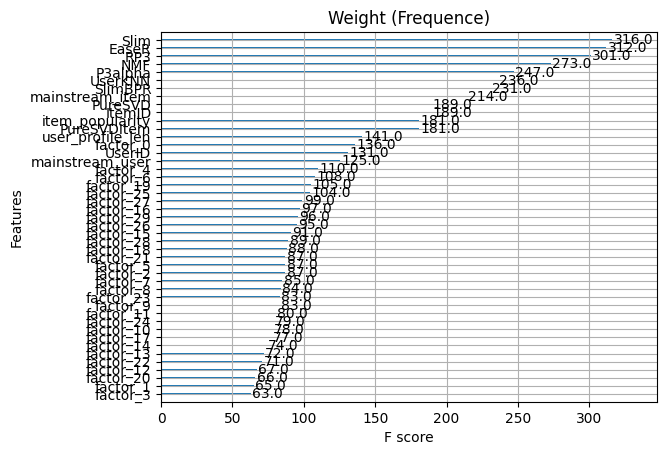

In [36]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [37]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4659.16 column/sec. Elapsed time 4.80 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4772.78 column/sec. Elapsed time 2.73 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3229.08 column/sec. Elapsed time 6.92 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3657.84 column/sec. Elapsed time 6.11 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [43]:
cutoff = 30
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = hybrid_similarity.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    validation_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'PureSVD'] = recommender_pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'NMF'] = recommender_nmf._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'PureSVDItem'] = recommender_pure_svd_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'SlimBPR'] = recommender_slim_bpr._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'Slim'] = recommender_slim._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'EaseR'] = recommender_ease_r._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    # validation_dataframe.loc[user_id, 'IALS'] = recommender_ials._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_46/1850901145.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_46/1850901145.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,UserKNN,RP3,P3alpha,PureSVD,NMF,PureSVDItem,SlimBPR,Slim,EaseR,item_popularity,user_profile_len
0,0,35,3.245894,0.551006,0.462268,0.499297,0.090663,0.069528,4.620020,0.409952,0.105850,571,34
1,0,100,2.917171,0.420816,0.346091,0.290667,0.282331,0.323509,6.470622,0.341064,0.090348,333,34
2,0,402,1.204698,0.217912,0.107374,0.078837,0.086212,0.101413,2.459290,0.223449,0.042138,104,34
3,0,505,1.330598,0.216487,0.135199,0.087505,0.111985,0.113512,4.543376,0.214502,0.038629,105,34
4,0,122,3.385918,0.194220,0.163266,-0.000697,0.012233,0.000000,4.398162,0.256333,0.013706,155,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,328,1.906008,0.140865,0.061742,0.181227,0.156967,0.149089,2.610978,0.129894,0.046220,154,60
390716,13023,11018,0.880402,0.174488,0.067351,0.028730,0.022804,0.043761,0.783922,0.134447,0.017211,7,60
390717,13023,842,1.726123,0.126505,0.052970,0.123655,0.135260,0.088759,0.854573,0.106516,0.029031,91,60
390718,13023,827,0.428111,0.126190,0.083310,0.034379,0.045749,0.067312,0.000000,0.055947,0.016060,68,60


In [44]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe

,UserID,ItemID,UserKNN,RP3,P3alpha,PureSVD,NMF,PureSVDItem,SlimBPR,Slim,...,factor_20,factor_21,factor_22,factor_23,factor_24,factor_25,factor_26,factor_27,factor_28,factor_29
0,0,35,3.245894,0.551006,0.462268,0.499297,0.090663,0.069528,4.620020,0.409952,...,-0.006688,-0.012757,-0.001610,-0.008500,0.002765,-0.008973,-0.003920,-0.006667,0.003139,-0.007231
1,0,100,2.917171,0.420816,0.346091,0.290667,0.282331,0.323509,6.470622,0.341064,...,-0.006688,-0.012757,-0.001610,-0.008500,0.002765,-0.008973,-0.003920,-0.006667,0.003139,-0.007231
2,0,402,1.204698,0.217912,0.107374,0.078837,0.086212,0.101413,2.459290,0.223449,...,-0.006688,-0.012757,-0.001610,-0.008500,0.002765,-0.008973,-0.003920,-0.006667,0.003139,-0.007231
3,0,505,1.330598,0.216487,0.135199,0.087505,0.111985,0.113512,4.543376,0.214502,...,-0.006688,-0.012757,-0.001610,-0.008500,0.002765,-0.008973,-0.003920,-0.006667,0.003139,-0.007231
4,0,122,3.385918,0.194220,0.163266,-0.000697,0.012233,0.000000,4.398162,0.256333,...,-0.006688,-0.012757,-0.001610,-0.008500,0.002765,-0.008973,-0.003920,-0.006667,0.003139,-0.007231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,328,1.906008,0.140865,0.061742,0.181227,0.156967,0.149089,2.610978,0.129894,...,0.011525,-0.016865,-0.005563,-0.007483,0.003702,-0.018765,-0.005399,-0.002397,0.009206,0.001715
390716,13023,11018,0.880402,0.174488,0.067351,0.028730,0.022804,0.043761,0.783922,0.134447,...,0.011525,-0.016865,-0.005563,-0.007483,0.003702,-0.018765,-0.005399,-0.002397,0.009206,0.001715
390717,13023,842,1.726123,0.126505,0.052970,0.123655,0.135260,0.088759,0.854573,0.106516,...,0.011525,-0.016865,-0.005563,-0.007483,0.003702,-0.018765,-0.005399,-0.002397,0.009206,0.001715
390718,13023,827,0.428111,0.126190,0.083310,0.034379,0.045749,0.067312,0.000000,0.055947,...,0.011525,-0.016865,-0.005563,-0.007483,0.003702,-0.018765,-0.005399,-0.002397,0.009206,0.001715


In [45]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

In [41]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [46]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 1.65 min. Users per second: 106


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096356,0.166537,0.141083,0.033872,0.049562,0.168556,0.114982,0.114507,0.527927,0.236458,...,0.802826,0.423833,0.802826,0.068226,10.443132,0.998238,0.196858,0.804498,1.649361,0.303


In [ ]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = 'rank:map',
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        three_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [ ]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [ ]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_xgboost_better', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

In [ ]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [ ]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [ ]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [ ]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [ ]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [ ]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['objective'] = 'rank:pairwise'
xgboost_params

In [ ]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

In [ ]:
cutoff = 30
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = hybrid_similarity.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    final_train_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'NMF'] = recommender_nmf._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'PureSVDItem'] = recommender_pure_svd_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'SlimBPR'] = recommender_slim_bpr._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'Slim'] = recommender_slim._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'EaseR'] = recommender_ease_r._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    # final_train_dataframe.loc[user_id, 'IALS'] = recommender_ials._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe

In [ ]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

In [ ]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

In [ ]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [ ]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

In [ ]:
cutoff = 30
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = hybrid_similarity.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    prediction_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'NMF'] = recommender_nmf._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'PureSVDItem'] = recommender_pure_svd_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'SlimBPR'] = recommender_slim_bpr._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'Slim'] = recommender_slim._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'EaseR'] = recommender_ease_r._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    # prediction_dataframe.loc[user_id, 'IALS'] = recommender_ials._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train, columns=[f'factor_{i}' for i in range(user_factors_final_train.shape[1])])

prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

In [ ]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [ ]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)